# STEP 0: PROJECT SETUP

### Import libraries:

In [1]:
import os
import random
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing import image as im
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\centli\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Set up local project directory:

In [2]:
os.chdir('E:/DeepLearning/dog_breeds')
print(os.getcwd())

E:\DeepLearning\dog_breeds


# STEP 1: PREPARE LABELS

### Read labels file and display the first and last 5 rows:

In [3]:
labels = pd.read_csv('labels.csv')
display(labels.iloc[np.r_[0:5, -5:0]])

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


### Select Train, Validate and Test sets at random from labels dataframe (70:15:15):

In [4]:
# set seed for reproducibility
random.seed(123)

# get list of all image id's in labels data
id_list = [id for id in labels.id]

# percentage assigned to train set (70% of total)
id_list_train = random.sample(id_list, int(np.round(len(id_list) * 0.70)))  

# remove images assigned to train set
id_list = [id for id in id_list if id not in id_list_train]  

# assign half of non-train images to validate set (15% of total)
id_list_validate = random.sample(id_list, int(np.round(len(id_list) * 0.50)))  

# remaining images are test set
id_list_test = [id for id in id_list if id not in id_list_validate]  

print(f"Total:{len(id_list)} / Train:{len(id_list_train)} / Validate:{len(id_list_validate)} / Test:{len(id_list_test)}")

Total:3067 / Train:7155 / Validate:1534 / Test:1533


# STEP 2: PREPARE IMAGES

### Resize images and copy them to Train, Validate and Test folders, and into each corresponding classification folder (Optional data augmentation):

In [27]:
# to bypass the data augmentation process set "augment_size = 0" 
def process_images(list_src, path_src, path_dst, subfolders, augment_size, img_size):    
    
    augment = im.ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                rescale=1/255, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

    for id in list_src:    
        
        if subfolders is True:                        
            breed = labels[labels.id == id].breed.item()  
        else:
            # no subfolders used
            breed = 'test' 
        
        # make subfolders using breed labels
        if not os.path.exists(f"{path_dst}{breed}"):
            os.makedirs(f"{path_dst}{breed}")
            
        # read and resize images            
        img = cv.imread(f"{path_src}{id}.jpg")    
        img = cv.resize(img, img_size)

        # save original images
        cv.imwrite(f"{path_dst}{breed}/{id}.jpg", img)    

        # save augmented images (optional)
        if augment_size > 0:            
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            x = img.reshape((1,) + img.shape)
            i = 0
            for batch in augment.flow(x, save_to_dir=f"{path_dst}{breed}", save_prefix=f"{id}", save_format='jpg'):
                i += 1
                if i >= augment_size:
                    break         
        
            
print('Image preparation in progress...')

process_images(id_list_train, 'downloaded/train/', 'train/', subfolders=True, augment_size=4, img_size=(128,128))
process_images(id_list_validate, 'downloaded/train/', 'validate/', subfolders=True, augment_size=4, img_size=(128,128))
process_images(id_list_test, 'downloaded/train/', 'test/', subfolders=False, augment_size=0, img_size=(128,128))

print('Image preparation completed successfully')

Image preparation in progress...
Image preparation completed successfully


### Display a few sample images from Train and Validate folders:

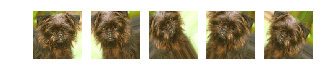

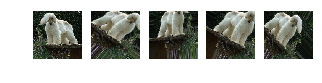

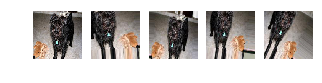

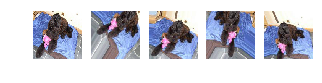

In [5]:
def sample_images(path, num_folders):

    dir_list = os.listdir(path)[0:num_folders]

    for dir in dir_list:     
        prefix = os.listdir(f'{path}{dir}')[0].replace('.jpg', '')    
        img_files = [filename for filename in os.listdir(f'{path}{dir}') if filename.startswith(prefix)]
        tot_img_files = len(img_files)

        fig = plt.figure(figsize=(tot_img_files, tot_img_files))            
        for k in range(0, tot_img_files):    
            fig.add_subplot(1, tot_img_files, k+1)
            plt.imshow(im.load_img(f'{path}{dir}/{img_files[k]}'))
            plt.axis('off')        
            
sample_images('train/', 2)
sample_images('validate/', 2)

### Optional: Read original and augmented images into dataframe:

In [6]:
def read_files(path):
    list_augmented = [filename for filename in os.listdir(path) if filename.endswith('jpg')]
    return list_augmented


def read_folders(path):
    list_folders = [foldername for foldername in os.listdir(path) if os.path.isdir(f'{path}/{foldername}')]
    return list_folders


def read_augmented_images(path):
    df_labels = pd.DataFrame(columns=['id', 'breed'])    
    folder_labels = read_folders(path)

    for folder in folder_labels:    
        folder_imgs = read_files(f'{path}{folder}')
        for file in folder_imgs:            
            file = file.replace('.jpg', '')
            df_labels = df_labels.append(pd.DataFrame([[file, folder]], columns=['id', 'breed']), ignore_index=True)
            
    return df_labels


def read_test_images(path):
    df_labels = pd.DataFrame(columns=['id', 'breed'])   
    folder_imgs = read_files(path)
    
    for img in folder_imgs:        
        id = img.replace('.jpg', '')
        breed = labels[labels.id == id].breed.item()
        df_labels = df_labels.append(pd.DataFrame([[id, breed]], columns=['id', 'breed']), ignore_index=True)
        
    return df_labels
    

print('Image reading in progress...')

labels_train = read_augmented_images('train/')
labels_validate = read_augmented_images('validate/')
labels_test = read_test_images('test/test/')

print('Image reading in completed successfully...')

Image reading in progress...
Image reading in completed successfully...


### Display head and tail of labels dataframe:

In [120]:
print('TRAIN SET:')
display(labels_train.iloc[np.r_[0:5, -5:0]])

print('VALIDATE SET:')
display(labels_validate.iloc[np.r_[0:5, -5:0]])

print('TEST SET:')
display(labels_test.iloc[np.r_[0:5, -5:0]])

TRAIN SET:


,id,breed
0,040fef64640b89c53f161b6c5215b78b,affenpinscher
1,040fef64640b89c53f161b6c5215b78b_0_1176,affenpinscher
2,040fef64640b89c53f161b6c5215b78b_0_1832,affenpinscher
3,040fef64640b89c53f161b6c5215b78b_0_1916,affenpinscher
4,040fef64640b89c53f161b6c5215b78b_0_9194,affenpinscher
35766,f7627680c56c5d3acc4f7eae93124459,yorkshire_terrier
35767,f7627680c56c5d3acc4f7eae93124459_0_361,yorkshire_terrier
35768,f7627680c56c5d3acc4f7eae93124459_0_5707,yorkshire_terrier
35769,f7627680c56c5d3acc4f7eae93124459_0_8393,yorkshire_terrier
35770,f7627680c56c5d3acc4f7eae93124459_0_841,yorkshire_terrier


VALIDATE SET:


,id,breed
0,01268f0007876a692907bda89468184c,affenpinscher
1,01268f0007876a692907bda89468184c_0_4323,affenpinscher
2,01268f0007876a692907bda89468184c_0_4473,affenpinscher
3,01268f0007876a692907bda89468184c_0_6094,affenpinscher
4,01268f0007876a692907bda89468184c_0_9651,affenpinscher
7662,e8827c1b0698e56e60f735b142d69d18,yorkshire_terrier
7663,e8827c1b0698e56e60f735b142d69d18_0_3890,yorkshire_terrier
7664,e8827c1b0698e56e60f735b142d69d18_0_497,yorkshire_terrier
7665,e8827c1b0698e56e60f735b142d69d18_0_5299,yorkshire_terrier
7666,e8827c1b0698e56e60f735b142d69d18_0_5836,yorkshire_terrier


TEST SET:


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
2,004396df1acd0f1247b740ca2b14616e,shetland_sheepdog
3,007b5a16db9d9ff9d7ad39982703e429,wire-haired_fox_terrier
4,00ca18751837cd6a22813f8e221f7819,affenpinscher
1528,fef4a58219c8971820a85868a7b073f5,tibetan_terrier
1529,fefb453e43ec5e840c323538261493bd,lhasa
1530,ffc532991d3cd7880d27a449ed1c4770,tibetan_terrier
1531,ffd25009d635cfd16e793503ac5edef0,borzoi
1532,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont


# STEP 3: PREPARE AND DEPLOY MODEL

In [9]:
#img = im.img_to_array(im.load_img(f"{path_src}{id}.jpg", target_size=(64, 64)))

train_set = im.ImageDataGenerator(rescale=1/255)
validate_set = im.ImageDataGenerator(rescale=1/255)
test_set = im.ImageDataGenerator(rescale=1/255)

train_gen = train_set.flow_from_directory('train', batch_size=50, target_size=(128, 128), class_mode='categorical')
validate_gen = train_set.flow_from_directory('validate', batch_size=50, target_size=(128, 128), class_mode='categorical')

test_gen = train_set.flow_from_directory('test', batch_size=50, target_size=(128, 128), class_mode=None, shuffle=False)
#test_gen = train_set.flow('test', labels_test, batch_size=1)

Found 35771 images belonging to 120 classes.
Found 7667 images belonging to 120 classes.
Found 1533 images belonging to 1 classes.


### CNN Model:

In [10]:
def dl_model():
    model = Sequential()
   
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())            
    
    model.add(Conv2D(128, (3, 3), activation='relu'))    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))    
    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())    
    
    model.add(Conv2D(256, (3, 3), activation='relu'))    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))    
        
    model.add(Dropout(0.5))                            
    model.add(Flatten())
        
    model.add(Dense(256, activation='relu'))    
    model.add(BatchNormalization())    
    
    model.add(Dense(120, activation='softmax'))    
              
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

model = dl_model()

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

### Model summary:

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 256)       295168    
__________

### Fit model:

In [12]:
with tf.device('/gpu:0'):
    logs = model.fit_generator(train_gen, steps_per_epoch=50, epochs=32, validation_data=validate_gen, validation_steps=50)

Epoch 1/32
50/50 [==============================] - 26s 527ms/step - loss: 0.0494 - acc: 0.9917 - val_loss: 0.0714 - val_acc: 0.9903
Epoch 2/32
50/50 [==============================] - 20s 398ms/step - loss: 0.0473 - acc: 0.9917 - val_loss: 0.0722 - val_acc: 0.9901
Epoch 3/32
50/50 [==============================] - 20s 392ms/step - loss: 0.0465 - acc: 0.9917 - val_loss: 0.0699 - val_acc: 0.9903
Epoch 4/32
50/50 [==============================] - 20s 394ms/step - loss: 0.0459 - acc: 0.9917 - val_loss: 0.0818 - val_acc: 0.9896
Epoch 5/32
50/50 [==============================] - 20s 392ms/step - loss: 0.0457 - acc: 0.9917 - val_loss: 0.0761 - val_acc: 0.9900
Epoch 6/32
50/50 [==============================] - 20s 392ms/step - loss: 0.0454 - acc: 0.9917 - val_loss: 0.0759 - val_acc: 0.9900
Epoch 7/32
50/50 [==============================] - 20s 392ms/step - loss: 0.0449 - acc: 0.9917 - val_loss: 0.0788 - val_acc: 0.9899
Epoch 8/32
50/50 [==============================] - 20s 392ms/step - 

### Plot training and validation accuracy:

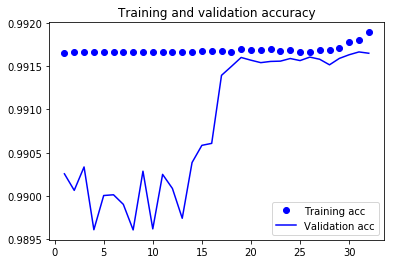

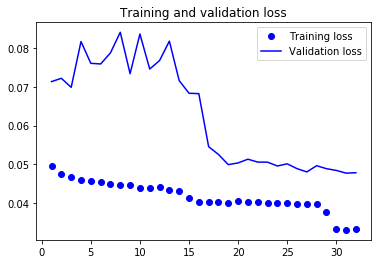

In [13]:
acc = logs.history['acc']
val_acc = logs.history['val_acc']
loss = logs.history['loss']
val_loss = logs.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Model evaluation using validation set:

In [253]:
scores = model.evaluate_generator(generator=validate_gen, verbose=1)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

154/154 [==============================] - 10s 63ms/step
CNN Error: 0.83%


### Run predictions on test set:

In [18]:
test_gen.reset()
predict = model.predict_generator(generator=test_gen, verbose=1)

31/31 [==============================] - 2s 64ms/step


### Prediction matrix:

In [288]:
breeds = train_gen.class_indices
breeds = dict((val, key) for key, val in breeds.items())

pred_colnames = list(breeds.values())
pred_colnames.insert(0, 'id')

prediction_matrix = pd.DataFrame(columns=pred_colnames)

for img in range(0, len(predict)):           
    pred_list = [pred for pred in predict[img]]
    pred_list.insert(0, compared['id'][img])
    prediction_matrix = prediction_matrix.append(pd.DataFrame([pred_list], columns=pred_colnames), ignore_index=True)    
    
print("Rows in prediction matrix:", len(prediction_matrix))

# display head and tail of prediction matrix from test set
prediction_matrix.iloc[np.r_[0:5, -5:0]]

Rows in prediction matrix: 1533


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000bec180eb18c7604dcecc8fe0dba07,0.002939,0.013731,0.001864,0.012835,0.001242,0.002960,0.015137,0.000693,0.001025,...,0.017306,0.001247,0.007832,0.000302,0.002769,0.019108,0.000514,0.000505,0.002166,0.000910
1,0021f9ceb3235effd7fcde7f7538ed62,0.004700,0.001557,0.003830,0.047468,0.003236,0.002275,0.032320,0.007694,0.001292,...,0.010409,0.008770,0.005309,0.000206,0.004977,0.002419,0.003659,0.008366,0.004552,0.014714
2,004396df1acd0f1247b740ca2b14616e,0.009076,0.024220,0.001697,0.019555,0.000523,0.001313,0.017242,0.000273,0.002183,...,0.019188,0.001452,0.001135,0.000657,0.004294,0.004892,0.004787,0.005856,0.005735,0.003972
3,007b5a16db9d9ff9d7ad39982703e429,0.003059,0.195118,0.002325,0.001117,0.002356,0.012319,0.009565,0.000309,0.000566,...,0.015484,0.002157,0.001022,0.000299,0.010843,0.000831,0.002353,0.001045,0.006398,0.004954
4,00ca18751837cd6a22813f8e221f7819,0.006625,0.008481,0.000825,0.057569,0.001170,0.001292,0.011256,0.000542,0.000574,...,0.012553,0.000720,0.002747,0.000302,0.008224,0.017925,0.004655,0.001244,0.003824,0.003877
1528,fef4a58219c8971820a85868a7b073f5,0.006538,0.014415,0.011375,0.058747,0.000946,0.001774,0.020556,0.002084,0.001489,...,0.035311,0.024197,0.002726,0.001819,0.019770,0.002701,0.002875,0.018634,0.005047,0.020097
1529,fefb453e43ec5e840c323538261493bd,0.010103,0.008116,0.001097,0.003699,0.001759,0.003803,0.004547,0.000575,0.000146,...,0.040452,0.001560,0.001281,0.001139,0.034217,0.002125,0.020442,0.021635,0.098002,0.001402
1530,ffc532991d3cd7880d27a449ed1c4770,0.016477,0.011403,0.001395,0.017853,0.001357,0.000906,0.003120,0.000768,0.000604,...,0.006980,0.003084,0.002697,0.000554,0.005697,0.001064,0.009394,0.006505,0.003396,0.005210
1531,ffd25009d635cfd16e793503ac5edef0,0.026602,0.021241,0.004479,0.033076,0.001105,0.028753,0.016672,0.000073,0.000291,...,0.008985,0.000439,0.002279,0.000407,0.014570,0.003948,0.000427,0.000696,0.001225,0.012746
1532,ffd3f636f7f379c51ba3648a9ff8254f,0.011149,0.002129,0.008336,0.002771,0.001093,0.001659,0.016203,0.001097,0.000311,...,0.082972,0.004417,0.003120,0.000566,0.016297,0.011525,0.004224,0.007275,0.012402,0.007127


### Compare original and predicted labels:

In [289]:
# get actual breed labels and predicted breed with highest probability of test set
test_labels_good = labels[labels.id.isin(id_list_test)]
test_labels_predicted = [breeds[key] for key in np.argmax(predict, axis=1)]

# compare the breed predicted by the model against the actual breed (show head and tail of result)
test_labels_good.reset_index(drop=True, inplace=True)
compared = test_labels_good.join(pd.DataFrame(test_labels_predicted, columns=['predicted']))
compared.iloc[np.r_[0:5, -5:0]]

,id,breed,predicted
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,irish_setter
1,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,chesapeake_bay_retriever
2,004396df1acd0f1247b740ca2b14616e,shetland_sheepdog,shih-tzu
3,007b5a16db9d9ff9d7ad39982703e429,wire-haired_fox_terrier,afghan_hound
4,00ca18751837cd6a22813f8e221f7819,affenpinscher,irish_setter
1528,fef4a58219c8971820a85868a7b073f5,tibetan_terrier,airedale
1529,fefb453e43ec5e840c323538261493bd,lhasa,wire-haired_fox_terrier
1530,ffc532991d3cd7880d27a449ed1c4770,tibetan_terrier,border_terrier
1531,ffd25009d635cfd16e793503ac5edef0,borzoi,irish_water_spaniel
1532,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,toy_poodle


In [126]:
# how many predictions did the model get right divided by total images in test set (percent)?

predictions_good = compared[compared['breed'] == compared['predicted']]
percent = round(len(predictions_good) / len(id_list_test) * 100, 2)
print("Good predictions:", len(predictions_good), "out of", len(id_list_test), "images (", percent, "% )")
predictions_good.iloc[np.r_[0:5, -5:0]]

Good predictions: 103 out of 1533 images ( 6.72 % )


,id,breed,predicted
11,01e2245b46eb747260ff80f1c892daef,brittany_spaniel,brittany_spaniel
35,06cd8e3fbfe72c34461814239e1deab8,keeshond,keeshond
38,07b5288a0bb8b9cf1a42d281a9451e51,irish_water_spaniel,irish_water_spaniel
48,08ea655aa168d87806340c336d07f1c9,dhole,dhole
87,0ddbc4702eff570783cd03645571e7f7,samoyed,samoyed
1402,eb40629be9b4a1676e2277d19c43e4b0,japanese_spaniel,japanese_spaniel
1429,efec77ba29d2407d82f808cf7ca79eb9,australian_terrier,australian_terrier
1436,f184f4ea0aad4cac48670bede5868054,scottish_deerhound,scottish_deerhound
1521,fdcf75632c624d8d03b37ddb1c6fc592,tibetan_mastiff,tibetan_mastiff
1522,fe49341352549164ad921a67647507f1,dandie_dinmont,dandie_dinmont


### Save model and predictions:

In [287]:
# save the model to local disk
model.save('dog_breeds_1.h5')

# save predictions as csv
prediction_matrix.to_csv("dog_breeds_predictions.csv", index=False)

# STEP 4: PREDICT KAGGLE TEST SET